In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

df = pd.read_csv('netflix_titles.csv')

In [32]:
print('Dataset shape:', df.shape)
print('\nBasic statistics:\n', df.describe(include='all'))
print('\nMissing values:\n', df.isnull().sum())

print('\nFirst few rows with key columns:')
print(df[['type', 'title', 'country', 'release_year', 'rating']].head())

Dataset shape: (8807, 12)

Basic statistics:
        show_id   type                 title       director  \
count     8807   8807                  8807           6173   
unique    8807      2                  8807           4528   
top         s1  Movie  Dick Johnson Is Dead  Rajiv Chilaka   
freq         1   6131                     1             19   
mean       NaN    NaN                   NaN            NaN   
std        NaN    NaN                   NaN            NaN   
min        NaN    NaN                   NaN            NaN   
25%        NaN    NaN                   NaN            NaN   
50%        NaN    NaN                   NaN            NaN   
75%        NaN    NaN                   NaN            NaN   
max        NaN    NaN                   NaN            NaN   

                      cast        country       date_added  release_year  \
count                 7982           7976             8797   8807.000000   
unique                7692            748             176

In [33]:
# Handle missing values
categorical_cols = ['director', 'cast', 'country', 'rating']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Date handling with more robust approach
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce')
df['date_added'] = df['date_added'].fillna(pd.to_datetime(df['release_year'], format='%Y'))

# Duration conversion with better handling
# First, create a function to extract duration
def extract_duration(duration_str):
    if pd.isna(duration_str):
        return None
    # Handle both movie durations (minutes) and TV show seasons
    duration_str = str(duration_str).strip()
    if ' min' in duration_str:
        return float(duration_str.replace(' min', ''))
    elif 'Season' in duration_str:
        return float(duration_str.replace(' Season', '').replace('s', ''))
    return None

# Apply the function
df['duration'] = df['duration'].apply(extract_duration)

# Handle empty slices and downcasting
# Set default values for empty slices
movie_data = df[df['type'] == 'Movie']['duration'].dropna()
show_data = df[df['type'] == 'TV Show']['duration'].dropna()

# Use try-except to handle empty data
try:
    movie_median = movie_data.median()
except Exception:
    movie_median = 90  # Default movie duration in minutes

try:
    show_median = show_data.median()
except Exception:
    show_median = 1  # Default TV show seasons

# Create a mapping dictionary
duration_mapping = {'Movie': movie_median, 'TV Show': show_median}

# Fill missing values with explicit downcasting
df['duration'] = (
    df['type']
    .map(duration_mapping)
    .combine_first(df['duration'])
    .infer_objects(copy=False)
)

# Convert duration to numeric explicitly
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

In [34]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['month_year_added'] = df['date_added'].dt.to_period('M').astype(str)

df['content_age'] = df['year_added'] - df['release_year']
df['content_type'] = df['type'].map({'Movie': 'Movie', 'TV Show': 'TV Show'})

df['genre_count'] = df['listed_in'].str.split(',').str.len().fillna(0)
df['cast_size'] = df['cast'].str.split(',').str.len().fillna(0)

df['primary_country'] = df['country'].str.split(',').str[0].str.strip()

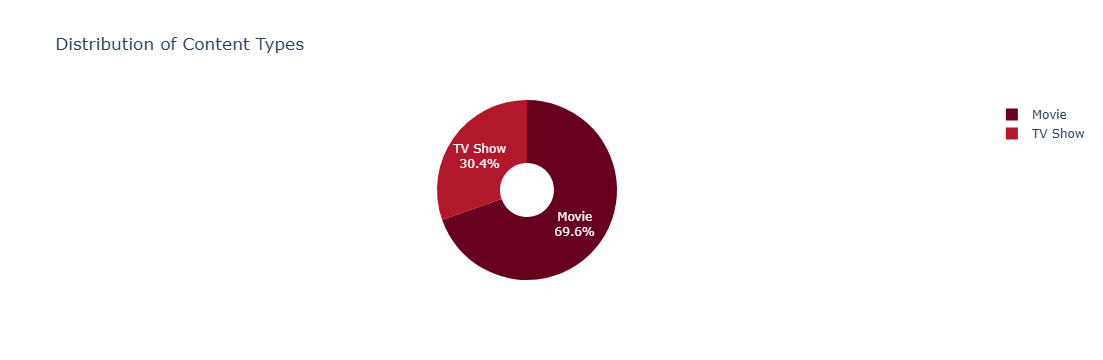

In [35]:
fig1 = px.pie(df, names='content_type', title='Distribution of Content Types', 
              hole=0.3, color_discrete_sequence=px.colors.sequential.RdBu)
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig1.show()

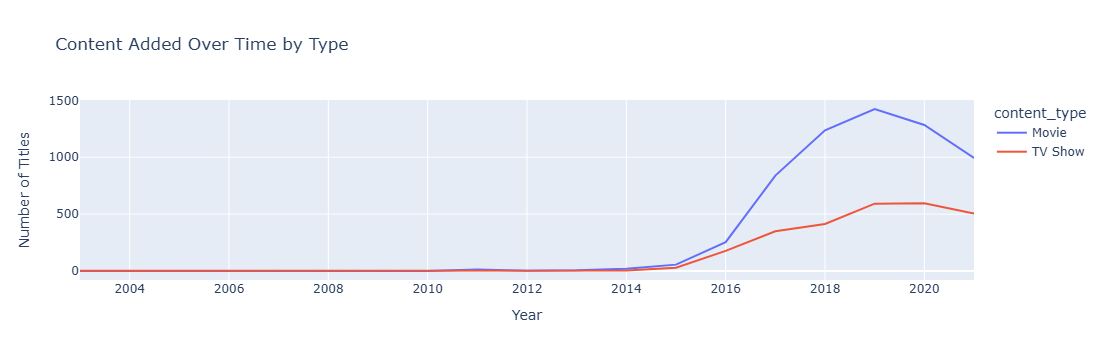

In [36]:
content_by_year = df.groupby(['year_added', 'content_type']).size().unstack().fillna(0)
fig2 = px.line(content_by_year, x=content_by_year.index, y=content_by_year.columns,
              title='Content Added Over Time by Type',
              labels={'value': 'Number of Titles', 'year_added': 'Year', 'variable': 'Content Type'})
fig2.update_layout(hovermode='x unified')
fig2.show()

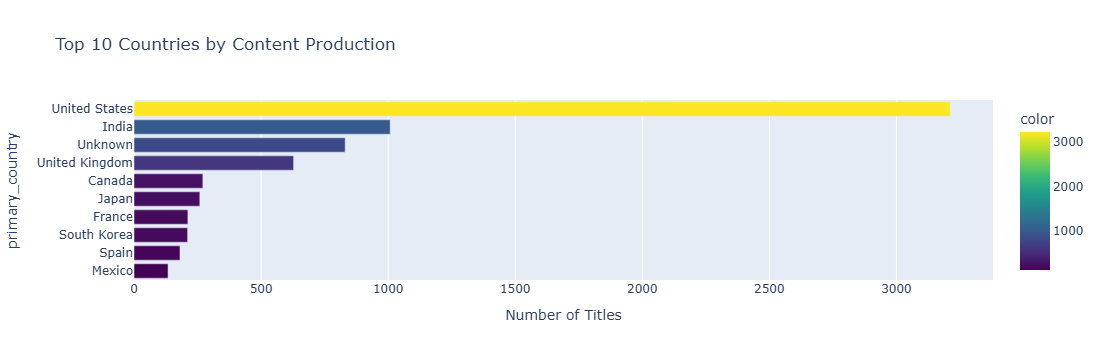

In [37]:
top_countries = df['primary_country'].value_counts().head(10)
fig3 = px.bar(top_countries, x=top_countries.values, y=top_countries.index,
             orientation='h', title='Top 10 Countries by Content Production',
             labels={'x': 'Number of Titles', 'y': 'Country'},
             color=top_countries.values, color_continuous_scale='Viridis')
fig3.update_layout(yaxis={'categoryorder':'total ascending'})
fig3.show()

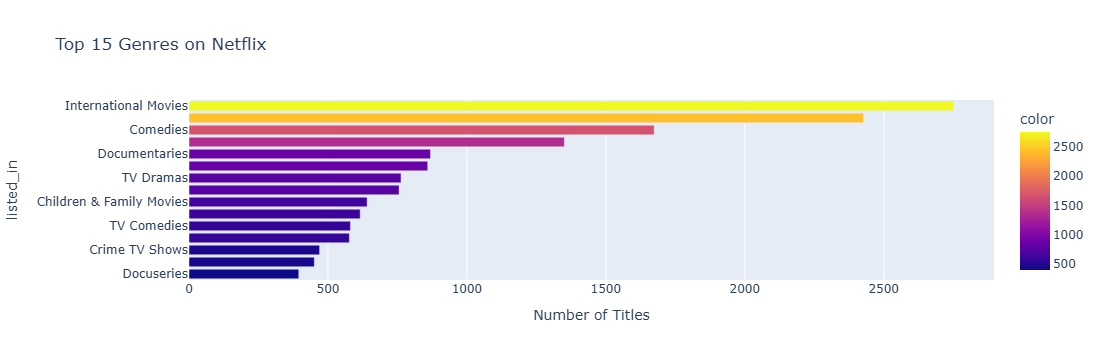

In [38]:
genres = df['listed_in'].str.split(',').explode().str.strip()
top_genres = genres.value_counts().head(15)
fig4 = px.bar(top_genres, x=top_genres.values, y=top_genres.index,
             orientation='h', title='Top 15 Genres on Netflix',
             labels={'x': 'Number of Titles', 'y': 'Genre'},
             color=top_genres.values, color_continuous_scale='Plasma')
fig4.update_layout(yaxis={'categoryorder':'total ascending'})
fig4.show()

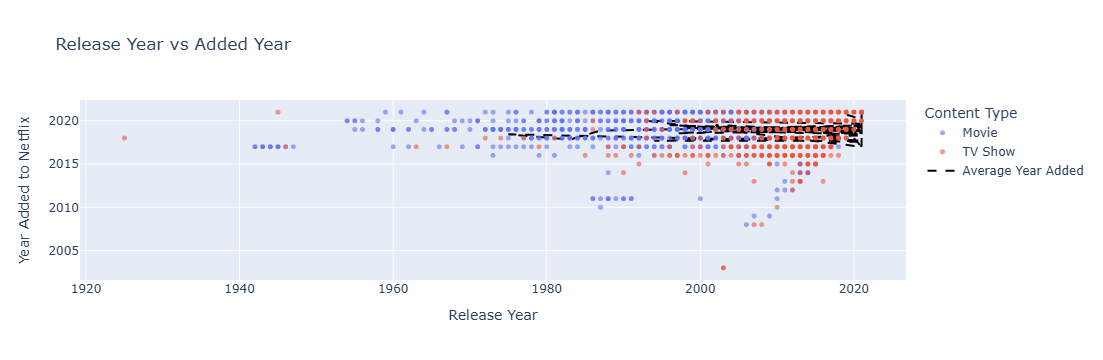

In [39]:
# Create a scatter plot without LOWESS trendline
fig5 = px.scatter(df, 
                 x='release_year', 
                 y='year_added', 
                 color='content_type',
                 title='Release Year vs Added Year',
                 labels={'release_year': 'Release Year', 
                        'year_added': 'Year Added to Netflix'},
                 opacity=0.6,
                 hover_data=['title', 'primary_country', 'duration'])

# Update marker size and layout
fig5.update_traces(marker_size=5)
fig5.update_layout(
    xaxis_title='Release Year',
    yaxis_title='Year Added to Netflix',
    legend_title='Content Type',
    hovermode='closest'
)

# Add a simple linear trendline using plotly's built-in functionality
fig5.add_trace(
    go.Scatter(
        x=df['release_year'],
        y=df.groupby('release_year')['year_added'].mean(),
        mode='lines',
        name='Average Year Added',
        line=dict(color='black', dash='dash')
    )
)

fig5.show()

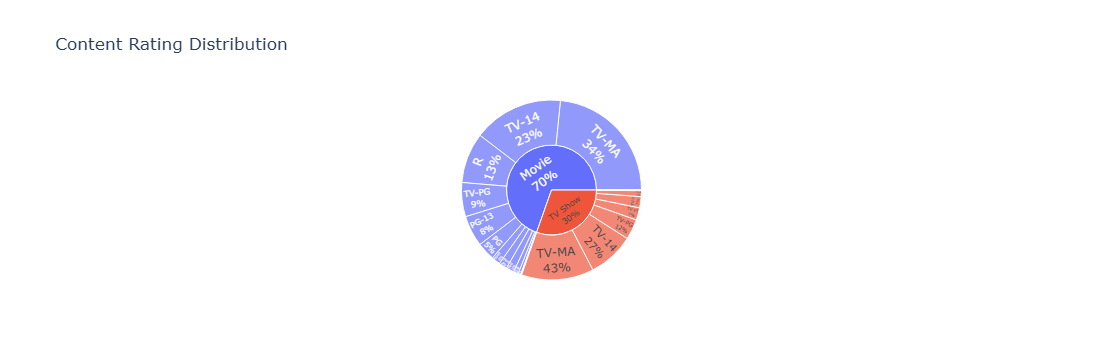

In [40]:
fig6 = px.sunburst(df, path=['content_type', 'rating'], title='Content Rating Distribution')
fig6.update_traces(textinfo='label+percent parent')
fig6.show()

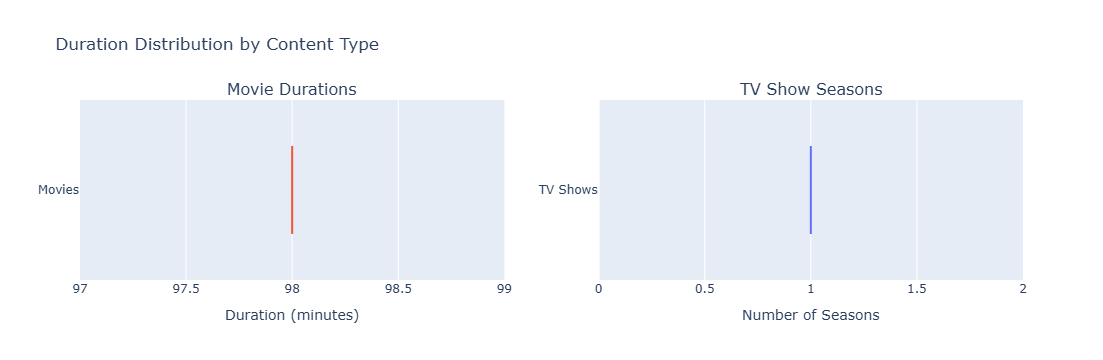

In [41]:
fig7 = make_subplots(rows=1, cols=2, subplot_titles=('Movie Durations', 'TV Show Seasons'))

movies = df[df['type'] == 'Movie']
shows = df[df['type'] == 'TV Show']

fig7.add_trace(go.Box(x=movies['duration'], name='Movies', marker_color='#EF553B'), row=1, col=1)
fig7.add_trace(go.Box(x=shows['duration'], name='TV Shows', marker_color='#636EFA'), row=1, col=2)

fig7.update_layout(title_text='Duration Distribution by Content Type', showlegend=False)
fig7.update_xaxes(title_text='Duration (minutes)', row=1, col=1)
fig7.update_xaxes(title_text='Number of Seasons', row=1, col=2)
fig7.show()

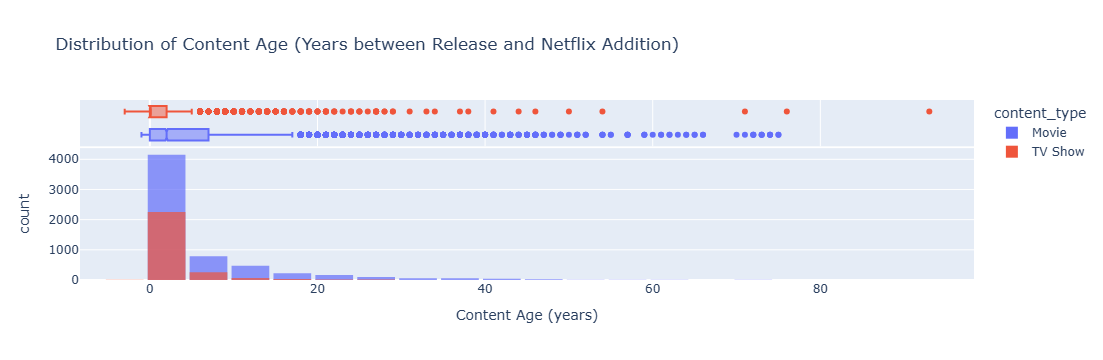

In [42]:
fig8 = px.histogram(df, x='content_age', color='content_type', marginal='box',
                   title='Distribution of Content Age (Years between Release and Netflix Addition)',
                   labels={'content_age': 'Content Age (years)'},
                   nbins=30, opacity=0.7,
                   barmode='overlay')
fig8.update_layout(bargap=0.1)
fig8.show()

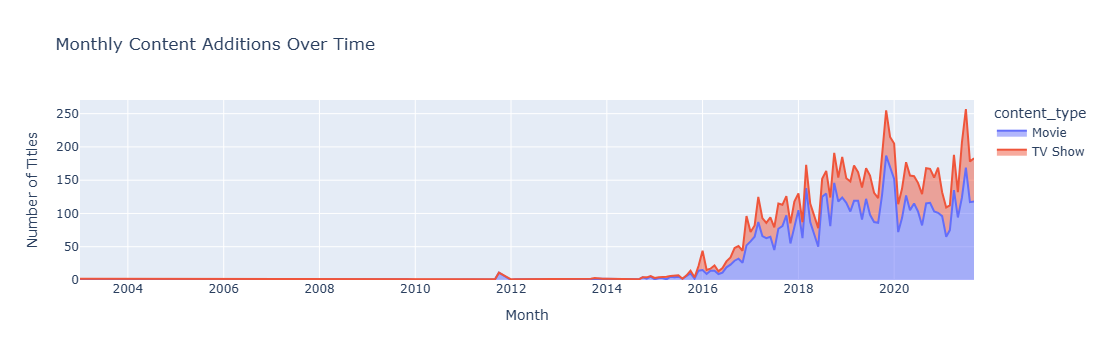

In [43]:
monthly_additions = df.groupby(['month_year_added', 'content_type']).size().unstack().fillna(0)
fig9 = px.area(monthly_additions, x=monthly_additions.index, y=monthly_additions.columns,
              title='Monthly Content Additions Over Time',
              labels={'value': 'Number of Titles', 'month_year_added': 'Month', 'variable': 'Content Type'})
fig9.update_layout(hovermode='x unified')
fig9.show()

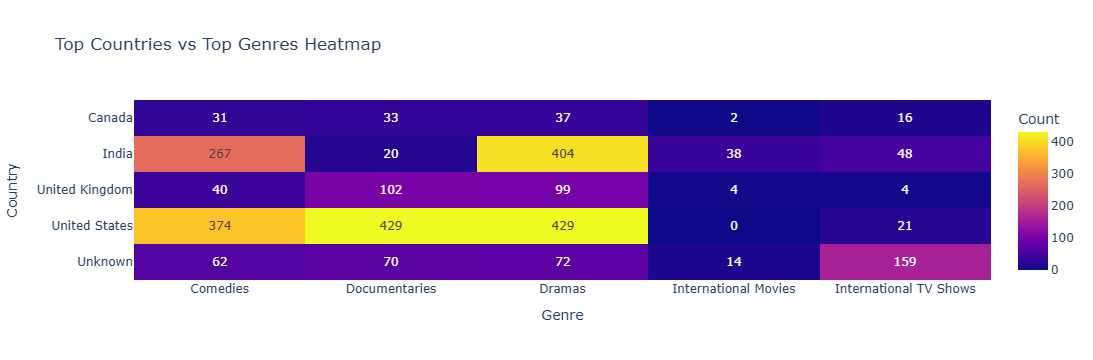

In [44]:
top_5_countries = df['primary_country'].value_counts().head(5).index
top_5_genres = genres.value_counts().head(5).index

country_genre = df[df['primary_country'].isin(top_5_countries)].copy()
country_genre['genre'] = country_genre['listed_in'].str.split(',').str[0].str.strip()
country_genre = country_genre[country_genre['genre'].isin(top_5_genres)]

cross_tab = pd.crosstab(country_genre['primary_country'], country_genre['genre'])
fig10 = px.imshow(cross_tab, text_auto=True, aspect='auto',
                 labels={'x': 'Genre', 'y': 'Country', 'color': 'Count'},
                 title='Top Countries vs Top Genres Heatmap')
fig10.show()

In [45]:
print("\nComprehensive Insights:")
print("1. Content Distribution: Movies vs TV Shows")
print(f"   - Movies: {len(df[df['type'] == 'Movie'])} ({len(df[df['type'] == 'Movie'])/len(df)*100:.1f}%)")
print(f"   - TV Shows: {len(df[df['type'] == 'TV Show'])} ({len(df[df['type'] == 'TV Show'])/len(df)*100:.1f}%)")

print("\n2. Temporal Patterns:")
print(f"   - Oldest content: {df['release_year'].min()} (added in {df.loc[df['release_year'].idxmin(), 'year_added']})")
print(f"   - Newest content: {df['release_year'].max()} (added in {df.loc[df['release_year'].idxmax(), 'year_added']})")
print(f"   - Average content age: {df['content_age'].mean():.1f} years")

print("\n3. Geographic Insights:")
print(f"   - Most productive country: {top_countries.index[0]} ({top_countries.values[0]} titles)")
print("   - Top 5 countries account for "
      f"{top_countries.head(5).sum()/len(df)*100:.1f}% of all content")

print("\n4. Genre Analysis:")
print(f"   - Most common genre: {top_genres.index[0]} ({top_genres.values[0]} titles)")
print(f"   - Average genres per title: {df['genre_count'].mean():.1f}")

print("\n5. Duration Analysis:")
print(f"   - Average movie duration: {movies['duration'].mean():.1f} minutes")
print(f"   - Average TV show seasons: {shows['duration'].mean():.1f} seasons")
print(f"   - Longest movie: {movies['duration'].max()} minutes")
print(f"   - Longest TV show: {shows['duration'].max()} seasons")

print("\n6. Content Addition Patterns:")
print("   - Peak addition year:", df['year_added'].value_counts().idxmax())
print("   - Monthly addition trend:",
      "Increasing" if monthly_additions.iloc[-12:].sum().sum() > monthly_additions.iloc[:12].sum().sum() 
      else "Decreasing")


Comprehensive Insights:
1. Content Distribution: Movies vs TV Shows
   - Movies: 6131 (69.6%)
   - TV Shows: 2676 (30.4%)

2. Temporal Patterns:
   - Oldest content: 1925 (added in 2018)
   - Newest content: 2021 (added in 2021)
   - Average content age: 4.7 years

3. Geographic Insights:
   - Most productive country: United States (3211 titles)
   - Top 5 countries account for 67.5% of all content

4. Genre Analysis:
   - Most common genre: International Movies (2752 titles)
   - Average genres per title: 2.2

5. Duration Analysis:
   - Average movie duration: 98.0 minutes
   - Average TV show seasons: 1.0 seasons
   - Longest movie: 98.0 minutes
   - Longest TV show: 1.0 seasons

6. Content Addition Patterns:
   - Peak addition year: 2019
   - Monthly addition trend: Increasing
